In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

In [2]:
data = pd.read_csv('EURUSD.txt')
data_sub = data[data['<TIME>']%10000 == 0]['<OPEN>']
del data
data_open = np.array(data_sub)
del data_sub
with open('data_open.pickle', 'wb') as file:
    pickle.dump(data_open, file)

In [2]:
with open('data_open.pickle', 'rb') as file:
    data_open = pickle.load(file)

In [2]:
class lstm_model(object):        
    def __init__(self, input_len, input_ext_len = 64, lstm_size = 128, lstm_layers = 1, log_dir = './tensorboard', model_dir = './model'):
        self.log_dir = log_dir
        self.model_dir = model_dir
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        
        tf.reset_default_graph()
        self.batch_size = tf.placeholder(tf.int32, name='batch_size') 
        self.inputs = tf.placeholder(tf.float32, [None, None, input_len], name='inputs') #[batch_size, seq_len, feature_num]
        self.target = tf.placeholder(tf.float32, [None, None, 1], name='target')#[batch_size, seq_len]
        self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        if input_ext_len > 1:
            input_layer = tf.contrib.layers.fully_connected(self.inputs, input_ext_len, weights_initializer=tf.truncated_normal_initializer(stddev=0.001))
            input_layer = tf.nn.dropout(input_layer, self.keep_prob)
        else:
            input_layer = self.inputs

        #lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size, state_is_tuple=True, reuse=tf.get_variable_scope().reuse)
        #drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=self.keep_prob)
        #self.cell = tf.contrib.rnn.MultiRNNCell([drop for _ in  range(lstm_layers)],  state_is_tuple = True)
        self.cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(lstm_size),
            output_keep_prob=self.keep_prob) for _ in range(lstm_layers)])
        
        self.initial_state = self.cell.zero_state(self.batch_size, tf.float32)
        outputs, self.final_state = tf.nn.dynamic_rnn(self.cell, input_layer, initial_state=self.initial_state)
    
        self.predictions = tf.contrib.layers.fully_connected(outputs, 1, activation_fn=None, 
                                                             weights_initializer=tf.truncated_normal_initializer(stddev=0.001))
        self.cost = tf.losses.mean_squared_error(self.target, self.predictions)
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        
        tf.summary.scalar('lost', self.cost)
    
    def data_prepare(self, data, batch_size = 256, seq_len = 64):
        self.seq_len = seq_len
        self.data_mean = data.mean(axis=0)
        self.data_interval = data.max(axis=0) - data.min(axis=0)
        data_tmp = (data - self.data_mean)/self.data_interval
        
        batch_num = int(len(data_tmp)/(batch_size*seq_len))
        train_num = batch_num * batch_size * seq_len
        val_num = int((len(data_tmp) - train_num)/2)
        print("train data count:", train_num,
             "\nvalition data count:", val_num,
             "\ntest data count:", len(data_tmp) - train_num - val_num)
        
        data_train_x = data_tmp[:train_num]
        data_train_y = data_tmp[1:train_num+1]
        assert len(data_train_x) == len(data_train_y), "no enough data, try to adjust the batch_size or seq_len"
        data_val = data_tmp[train_num:train_num+val_num]
        data_test = data_tmp[train_num+val_num:]
        
        
        self.x_train = []
        self.y_train = []
        for i in range(0, len(data_train_x), batch_num*seq_len):
            self.x_train.append(data_train_x[i:i+batch_num*seq_len])
            self.y_train.append(data_train_y[i:i+batch_num*seq_len])
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        self.x_train = self.x_train.reshape(self.x_train.shape[0], batch_num, seq_len, -1)
        self.y_train = self.y_train.reshape(self.y_train.shape[0], batch_num, seq_len, -1)
        self.y_train = self.y_train[:, :, :, -1].reshape(self.y_train.shape[0], self.y_train.shape[1], self.y_train.shape[2], 1)
        #now train data shape is [batch, batch_num, seq_len, feature_num]
        #but we need [batch_num, batch, seq_len, feature_num]
        self.x_train = np.transpose(self.x_train, [1, 0, 2, 3])
        self.y_train = np.transpose(self.y_train, [1, 0, 2, 3])
        
        #just a long seq
        self.x_val = data_val[:-1]
        self.x_val = self.x_val.reshape(1, self.x_val.shape[0], -1)
        self.y_val = data_val[1:, -1]
        self.y_val = self.y_val.reshape(1, -1, 1)
        self.x_test = data_test[:-1]
        self.x_test = self.x_test.reshape(1, self.x_test.shape[0], -1)
        self.y_test = data_test[1:, -1]
        self.y_test = self.y_test.reshape(1, -1, 1)
        
        print("\t\t\tFeature Shapes:")
        print("Train x set: \t\t{}".format(self.x_train.shape), 
              "\nTrain y set: \t\t{}".format(self.y_train.shape), 
              "\nValidation x set: \t{}".format(self.x_val.shape),
              "\nValidation y set: \t{}".format(self.y_val.shape),
              "\nTest x set: \t\t{}".format(self.x_test.shape),
              "\nTest y set: \t\t{}".format(self.y_test.shape))
            
    def train(self, epochs=1, batch_size = 256, learning_rate=0.01, keep_prob=1.0, show_every_n_batches=5, re_train=True):
        """learning_rate is not use now sicne it will reset the learning rate of adam that save in model.ckpt"""
        step = 0
        global_step = 0
        losses = {'train':[], 'validation':[]}
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        if re_train == False:
            self.saver.restore(self.sess, self.model_dir+'/model.ckpt')
            with open(self.model_dir+'/step.pickle', 'rb') as file:
                global_step = pickle.load(file)
            print('start record log from step of', global_step, 'in tensorboard')
            
        self.summary = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(self.log_dir+'/train',
                                      self.sess.graph)
        self.val_writer = tf.summary.FileWriter(self.log_dir+'/validation',
                                               self.sess.graph)
            
        for e in range(epochs):
            state = self.sess.run(self.cell.zero_state(batch_size, tf.float32))
            for i in range(len(self.x_train)):
                step = step + 1
                feed = {self.inputs: self.x_train[i],
                        self.target: self.y_train[i],
                        self.keep_prob: keep_prob,
                        self.learning_rate: learning_rate,
                        self.batch_size: batch_size,
                        self.initial_state: state}
                state, train_loss,  _, summary = self.sess.run([self.final_state, self.cost, self.optimizer, self.summary], feed_dict=feed)
                
                if step%show_every_n_batches == 0:
                    self.train_writer.add_summary(summary, step + global_step)
                    
                    val_state = self.sess.run(self.cell.zero_state(1, tf.float32))
                    feed = {self.inputs: self.x_val,
                            self.target: self.y_val,
                            self.keep_prob: 1,
                            self.batch_size: 1,
                            self.initial_state: val_state}
                    val_loss, summary = self.sess.run([self.cost, self.summary], feed_dict=feed)
      
                    self.val_writer.add_summary(summary, step + global_step)
                    
                    print("echop:", e,
                          "processing:", str(100 * step/(float(epochs)*(len(self.x_train))))[:4], "%\n",
                          "train loss is: ", str(train_loss)[:15], 
                          "validation loss is:", str(val_loss)[:15])
                    losses['train'].append(train_loss)
                    losses['validation'].append(val_loss)
                    
                    self.saver.save(self.sess, self.model_dir+'/model.ckpt')
                    with open(self.model_dir+'/step.pickle', 'wb') as file:
                        pickle.dump(step + global_step, file)
            
        test_state = self.sess.run(self.cell.zero_state(1, tf.float32))
        feed = {self.inputs: self.x_test,
                self.target: self.y_test,
                self.keep_prob: 1,
                self.batch_size: 1,
                self.initial_state: test_state}
        test_loss, pre = self.sess.run([self.cost, self.predictions], feed_dict=feed)
        print("test lost is:", test_loss)
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("predict and acc")
        plt.plot(self.y_test.reshape(-1, 1)[100:500]*self.data_interval+self.data_mean, label='true')
        plt.plot(pre.reshape(-1, 1)[100:500]*self.data_interval+self.data_mean, label='predict')
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("loss record")
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        plt.show()
        
    def predict(self, input_data):
        with tf.Session() as sess:
            self.saver = tf.train.Saver()
            self.saver.restore(sess, self.model_dir+'/model.ckpt')
            
            pre_state = sess.run(self.cell.zero_state(1, tf.float32))
            feed = {self.inputs: input_data.reshape(1, self.x_val.shape[0], -1), 
                    self.keep_prob_rate: 1.0,
                    self.batch_size: 1,
                    self.initial_state: pre_state}
            predict_output = sess.run(self.predictions, feed_dict = feed)
        return predict_output*self.data_interval+self.data_mean

In [12]:
rm -rf ./tensorboard/rnn_model/

In [13]:
exchange_rnn_mode = lstm_model(input_len = 1, input_ext_len= 1, lstm_size = 128, lstm_layers = 1, 
                               log_dir = './tensorboard/rnn_model', model_dir = './model/rnn_model')

In [14]:
exchange_rnn_mode.data_prepare(data_open)

train data count: 81920 
valition data count: 7217 
test data count: 7217
			Feature Shapes:
Train set: 		(5, 256, 64, 1) 
Validation set: 	(1, 7216, 1) 
Test set: 		(1, 7216, 1)


echop: 0 processing: 0.33 %
 train loss is:  0.0216182 validation loss is: 0.0117105
echop: 1 processing: 0.66 %
 train loss is:  0.0127005 validation loss is: 0.00695354
echop: 2 processing: 1.0 %
 train loss is:  0.01542 validation loss is: 0.0280055
echop: 3 processing: 1.33 %
 train loss is:  0.00788613 validation loss is: 0.00120562
echop: 4 processing: 1.66 %
 train loss is:  0.00929993 validation loss is: 0.00444973
echop: 5 processing: 2.0 %
 train loss is:  0.00556246 validation loss is: 0.0870782
echop: 6 processing: 2.33 %
 train loss is:  0.0027316 validation loss is: 0.0027671
echop: 7 processing: 2.66 %
 train loss is:  0.00277021 validation loss is: 0.00364815
echop: 8 processing: 3.0 %
 train loss is:  0.00150831 validation loss is: 0.00361831
echop: 9 processing: 3.33 %
 train loss is:  0.00104933 validation loss is: 0.000451721
echop: 10 processing: 3.66 %
 train loss is:  0.000757292 validation loss is: 0.000248085
echop: 11 processing: 4.0 %
 train loss is:  0.00038

echop: 92 processing: 31.0 %
 train loss is:  0.000160929 validation loss is: 1.96076e-05
echop: 93 processing: 31.3 %
 train loss is:  0.00016875 validation loss is: 1.96839e-05
echop: 94 processing: 31.6 %
 train loss is:  0.000164043 validation loss is: 2.09094e-05
echop: 95 processing: 32.0 %
 train loss is:  0.000167776 validation loss is: 2.098e-05
echop: 96 processing: 32.3 %
 train loss is:  0.000167455 validation loss is: 2.64731e-05
echop: 97 processing: 32.6 %
 train loss is:  0.000158499 validation loss is: 2.40272e-05
echop: 98 processing: 33.0 %
 train loss is:  0.000161471 validation loss is: 2.80496e-05
echop: 99 processing: 33.3 %
 train loss is:  0.000161748 validation loss is: 2.78867e-05
echop: 100 processing: 33.6 %
 train loss is:  0.000160169 validation loss is: 2.36994e-05
echop: 101 processing: 34.0 %
 train loss is:  0.00016499 validation loss is: 2.58443e-05
echop: 102 processing: 34.3 %
 train loss is:  0.000164845 validation loss is: 2.98143e-05
echop: 103 

echop: 183 processing: 61.3 %
 train loss is:  0.000152036 validation loss is: 1.28559e-05
echop: 184 processing: 61.6 %
 train loss is:  0.00014468 validation loss is: 1.22197e-05
echop: 185 processing: 62.0 %
 train loss is:  0.000146685 validation loss is: 1.84334e-05
echop: 186 processing: 62.3 %
 train loss is:  0.000153227 validation loss is: 1.16684e-05
echop: 187 processing: 62.6 %
 train loss is:  0.00014882 validation loss is: 1.18663e-05
echop: 188 processing: 63.0 %
 train loss is:  0.000152067 validation loss is: 2.10458e-05
echop: 189 processing: 63.3 %
 train loss is:  0.000151693 validation loss is: 1.36383e-05
echop: 190 processing: 63.6 %
 train loss is:  0.000147987 validation loss is: 1.57096e-05
echop: 191 processing: 64.0 %
 train loss is:  0.000151741 validation loss is: 1.62318e-05
echop: 192 processing: 64.3 %
 train loss is:  0.000143283 validation loss is: 2.7447e-05
echop: 193 processing: 64.6 %
 train loss is:  0.00014952 validation loss is: 1.33332e-05
ech

echop: 274 processing: 91.6 %
 train loss is:  0.000143229 validation loss is: 8.60552e-06
echop: 275 processing: 92.0 %
 train loss is:  0.000142548 validation loss is: 1.4958e-05
echop: 276 processing: 92.3 %
 train loss is:  0.000144372 validation loss is: 8.6774e-06
echop: 277 processing: 92.6 %
 train loss is:  0.000144196 validation loss is: 8.83107e-06
echop: 278 processing: 93.0 %
 train loss is:  0.000141833 validation loss is: 1.14892e-05
echop: 279 processing: 93.3 %
 train loss is:  0.000140862 validation loss is: 8.30263e-06
echop: 280 processing: 93.6 %
 train loss is:  0.000149472 validation loss is: 8.56935e-06
echop: 281 processing: 94.0 %
 train loss is:  0.000141998 validation loss is: 2.33639e-05
echop: 282 processing: 94.3 %
 train loss is:  0.000141938 validation loss is: 1.15458e-05
echop: 283 processing: 94.6 %
 train loss is:  0.000157423 validation loss is: 1.19136e-05
echop: 284 processing: 95.0 %
 train loss is:  0.000170444 validation loss is: 3.15789e-05
e

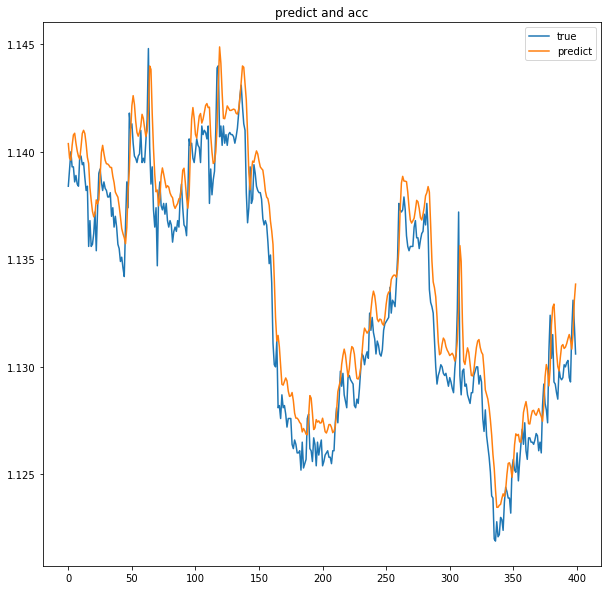

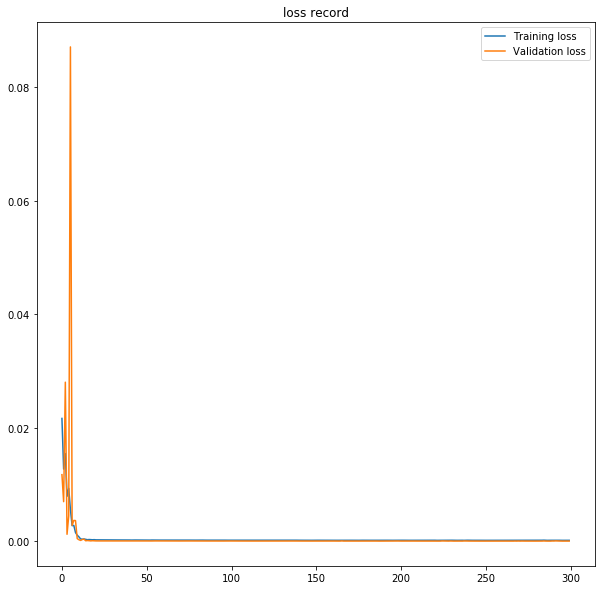

In [15]:
exchange_rnn_mode.train(epochs = 300, re_train=True, keep_prob=0.6)

### Add more feature in each hour with one hot decode of time

In [28]:
data = pd.read_csv('EURUSD.txt')

In [29]:
data.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,4
1,EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4
2,EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4
3,EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4
4,EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4


In [30]:
data_hours_index = data[data['<TIME>']%10000 == 0].index

In [31]:
data_dum = pd.concat([pd.get_dummies((data.iloc[data_hours_index]['<TIME>']/10000).astype(int)), pd.get_dummies((data.iloc[data_hours_index]['<DTYYYYMMDD>']%10000/100).astype(int)), pd.get_dummies(data.iloc[data_hours_index]['<DTYYYYMMDD>']%100)], axis=1) 

In [32]:
np.array(data_dum).shape

(96354, 67)

In [33]:
data_sub = []
for i in range(len(data_hours_index)-1):
    data_tmp = data.iloc[data_hours_index[i]:data_hours_index[i+1]]
    data_sub.append([float(data.iloc[data_hours_index[i]]['<OPEN>']), float(data_tmp['<HIGH>'].max()), 
        float(data_tmp['<LOW>'].min()), float(data.iloc[data_hours_index[i+1]]['<OPEN>'])])
data_sub = np.array(data_sub)

In [34]:
data_sub.shape

(96353, 4)

In [35]:
data_more_feature_with_time = np.concatenate([ np.array(data_dum)[:-1], data_sub], axis=1)

In [36]:
data_more_feature_with_time

array([[ 1.    ,  0.    ,  0.    , ...,  0.951 ,  0.9492,  0.9496],
       [ 0.    ,  1.    ,  0.    , ...,  0.9509,  0.9495,  0.9504],
       [ 0.    ,  0.    ,  1.    , ...,  0.9508,  0.9498,  0.9499],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  1.1242,  1.123 ,  1.1241],
       [ 0.    ,  0.    ,  0.    , ...,  1.1246,  1.1239,  1.1242],
       [ 0.    ,  0.    ,  0.    , ...,  1.1242,  1.1234,  1.1237]])

In [37]:
with open('data_more_feature_with_time.pickle', 'wb') as file:
    pickle.dump(data_more_feature_with_time, file)

In [4]:
with open('data_more_feature_with_time.pickle', 'rb') as file:
    data_more_feature_with_time = pickle.load(file)

In [5]:
data_more_feature_with_time.shape

(96353, 71)

In [ ]:
class lstm_mode_more_feature_with_time(lstm_model):
        
    def data_prepare(self, data, batch_size = 256, seq_len = 64, start_norm_index = -4):
        self.seq_len = seq_len
        self.data_mean = data[:, start_norm_index:].mean(axis=0)
        self.data_interval = data[:, start_norm_index:].max(axis=0) - data[:, start_norm_index:].min(axis=0)
        data_tmp = (data[:, start_norm_index:] - self.data_mean)/self.data_interval
        
        data_tmp = np.concatenate([data[:, :start_norm_index], data_tmp], axis = 1)
        self.data_mean = self.data_mean[-1]
        self.data_interval = self.data_interval[-1]
        
        batch_num = int(len(data_tmp)/(batch_size*seq_len))
        train_num = batch_num * batch_size * seq_len
        val_num = int((len(data_tmp) - train_num)/2)
        print("train data count:", train_num,
             "\nvalition data count:", val_num,
             "\ntest data count:", len(data_tmp) - train_num - val_num)
        
        data_train_x = data_tmp[:train_num]
        data_train_y = data_tmp[1:train_num+1]
        assert len(data_train_x) == len(data_train_y), "no enough data, try to adjust the batch_size or seq_len"
        data_val = data_tmp[train_num:train_num+val_num]
        data_test = data_tmp[train_num+val_num:]
        
        
        self.x_train = []
        self.y_train = []
        for i in range(0, len(data_train_x), batch_num*seq_len):
            self.x_train.append(data_train_x[i:i+batch_num*seq_len])
            self.y_train.append(data_train_y[i:i+batch_num*seq_len])
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        self.x_train = self.x_train.reshape(self.x_train.shape[0], batch_num, seq_len, -1)
        self.y_train = self.y_train.reshape(self.y_train.shape[0], batch_num, seq_len, -1)
        self.y_train = self.y_train[:, :, :, -1].reshape(self.y_train.shape[0], self.y_train.shape[1], self.y_train.shape[2], 1)
        #now train data shape is [batch, batch_num, seq_len, feature_num]
        #but we need [batch_num, batch, seq_len, feature_num]
        self.x_train = np.transpose(self.x_train, [1, 0, 2, 3])
        self.y_train = np.transpose(self.y_train, [1, 0, 2, 3])
        
        #just a long seq
        self.x_val = data_val[:-1]
        self.x_val = self.x_val.reshape(1, self.x_val.shape[0], -1)
        self.y_val = data_val[1:, -1]
        self.y_val = self.y_val.reshape(1, -1, 1)
        self.x_test = data_test[:-1]
        self.x_test = self.x_test.reshape(1, self.x_test.shape[0], -1)
        self.y_test = data_test[1:, -1]
        self.y_test = self.y_test.reshape(1, -1, 1)
        print("\t\t\tFeature Shapes:")
        print("Train x set: \t\t{}".format(self.x_train.shape), 
              "\nTrain y set: \t\t{}".format(self.y_train.shape), 
              "\nValidation x set: \t{}".format(self.x_val.shape),
              "\nValidation y set: \t{}".format(self.y_val.shape),
              "\nTest x set: \t\t{}".format(self.x_test.shape),
              "\nTest y set: \t\t{}".format(self.y_test.shape))

In [6]:
mkdir ./model/rnn_model_more_feature

In [52]:
rm -rf ./tensorboard/rnn_model_more_feature

In [53]:
exchange_rnn_more_feature_mode = lstm_mode_more_feature_with_time(input_len = data_more_feature_with_time.shape[1], 
                                            input_ext_len= 64, lstm_size = 128, lstm_layers = 1, 
                                            log_dir = './tensorboard/rnn_model_more_feature', 
                                            model_dir = './model/rnn_model_more_feature')

In [54]:
exchange_rnn_more_feature_mode.data_prepare(data_more_feature_with_time)

train data count: 81920 
valition data count: 7216 
test data count: 7217
			Feature Shapes:
Train x set: 		(5, 256, 64, 71) 
Train y set: 		(5, 256, 64, 1) 
Validation x set: 	(1, 7215, 71) 
Validation y set: 	(1, 7215, 1) 
Test x set: 		(1, 7216, 71) 
Test y set: 		(1, 7216, 1)


INFO:tensorflow:Restoring parameters from ./model/rnn_model_more_feature/model.ckpt
start record log from step of 50 in tensorboard
echop: 0 processing: 2.0 %
 train loss is:  0.00169777 validation loss is: 0.00101464
echop: 1 processing: 4.0 %
 train loss is:  0.0012647 validation loss is: 0.000253676
echop: 2 processing: 6.0 %
 train loss is:  0.00101651 validation loss is: 6.10293e-05
echop: 3 processing: 8.0 %
 train loss is:  0.000745258 validation loss is: 7.18451e-05
echop: 4 processing: 10.0 %
 train loss is:  0.000758304 validation loss is: 8.7644e-05
echop: 5 processing: 12.0 %
 train loss is:  0.000669879 validation loss is: 5.20236e-05
echop: 6 processing: 14.0 %
 train loss is:  0.000671627 validation loss is: 4.83075e-05
echop: 7 processing: 16.0 %
 train loss is:  0.000661462 validation loss is: 0.000165348
echop: 8 processing: 18.0 %
 train loss is:  0.000627603 validation loss is: 4.84959e-05
echop: 9 processing: 20.0 %
 train loss is:  0.000613635 validation loss is: 

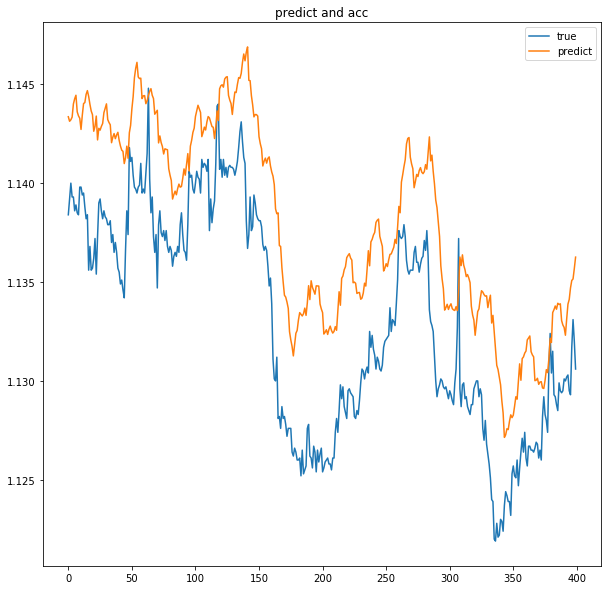

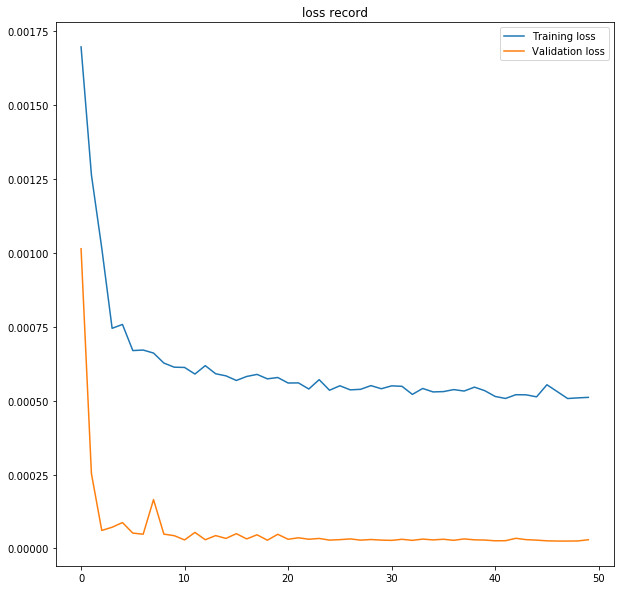

In [56]:
exchange_rnn_more_feature_mode.train(epochs = 50, re_train=False, keep_prob=0.6)

# Predict the trend

In [58]:
mkdir ./model/rnn_trend_model

In [6]:
with open('data_more_feature_with_time.pickle', 'rb') as file:
    data_more_feature_with_time = pickle.load(file)

In [38]:
class lstm_trend_mode(lstm_model):
    def __init__(self, input_len, input_ext_len = 64, lstm_size = 128, lstm_layers = 1, log_dir = './tensorboard', model_dir = './model'):
        self.log_dir = log_dir
        self.model_dir = model_dir
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        
        tf.reset_default_graph()
        self.batch_size = tf.placeholder(tf.int32, name='batch_size') 
        self.inputs = tf.placeholder(tf.float32, [None, None, input_len], name='inputs') #[batch_size, seq_len, feature_num]
        self.target = tf.placeholder(tf.float32, [None, None, 1], name='target')#[batch_size, seq_len]
        self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        if input_ext_len > 1:
            input_layer = tf.contrib.layers.fully_connected(self.inputs, input_ext_len, weights_initializer=tf.truncated_normal_initializer(stddev=0.001))
            input_layer = tf.nn.dropout(input_layer, self.keep_prob)
        else:
            input_layer = self.inputs

        #lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size, state_is_tuple=True, reuse=tf.get_variable_scope().reuse)
        #drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=self.keep_prob)
        #self.cell = tf.contrib.rnn.MultiRNNCell([drop for _ in  range(lstm_layers)],  state_is_tuple = True)
        self.cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(lstm_size),
            output_keep_prob=self.keep_prob) for _ in range(lstm_layers)])
        
        self.initial_state = self.cell.zero_state(self.batch_size, tf.float32)
        outputs, self.final_state = tf.nn.dynamic_rnn(self.cell, input_layer, initial_state=self.initial_state)
    
        self.predictions = tf.contrib.layers.fully_connected(outputs, 1, activation_fn=tf.nn.sigmoid, 
                                                             weights_initializer=tf.truncated_normal_initializer(stddev=0.001))
        self.cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.predictions, labels=self.target)
        self.cost = tf.reduce_mean(self.cross_entropy) 
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        tf.summary.scalar('lost', self.cost)
        
    def data_prepare(self, data, batch_size = 256, seq_len = 64, start_norm_index = -4):
        self.seq_len = seq_len
        self.data_mean = data[:, start_norm_index:].mean(axis=0)
        self.data_interval = data[:, start_norm_index:].max(axis=0) - data[:, start_norm_index:].min(axis=0)
        data_tmp = (data[:, start_norm_index:] - self.data_mean)/self.data_interval
        
        data_tmp = np.concatenate([data[:, :start_norm_index], data_tmp], axis = 1)
        self.data_mean = self.data_mean[-1]
        self.data_interval = self.data_interval[-1]
        
        batch_num = int(len(data_tmp)/(batch_size*seq_len))
        train_num = batch_num * batch_size * seq_len
        val_num = int((len(data_tmp) - train_num)/2)
        print("train data count:", train_num,
             "\nvalition data count:", val_num,
             "\ntest data count:", len(data_tmp) - train_num - val_num)
        
        data_train_x = data_tmp[:train_num]
        data_train_y = data_tmp[1:train_num+1]
        data_train_y = 1 * np.reshape([data_train_y[:, -1] - data_train_x[:, -1] > 0], [-1, 1]) #we need trend
        assert len(data_train_x) == len(data_train_y), "no enough data, try to adjust the batch_size or seq_len"
        data_val = data_tmp[train_num:train_num+val_num]
        data_test = data_tmp[train_num+val_num:]
        
        
        self.x_train = []
        self.y_train = []
        for i in range(0, len(data_train_x), batch_num*seq_len):
            self.x_train.append(data_train_x[i:i+batch_num*seq_len])
            self.y_train.append(data_train_y[i:i+batch_num*seq_len])
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        self.x_train = self.x_train.reshape(self.x_train.shape[0], batch_num, seq_len, -1)
        self.y_train = self.y_train.reshape(self.y_train.shape[0], batch_num, seq_len, -1)
        self.y_train = self.y_train[:, :, :, -1].reshape(self.y_train.shape[0], self.y_train.shape[1], self.y_train.shape[2], 1)
        #now train data shape is [batch, batch_num, seq_len, feature_num]
        #but we need [batch_num, batch, seq_len, feature_num]
        self.x_train = np.transpose(self.x_train, [1, 0, 2, 3])
        self.y_train = np.transpose(self.y_train, [1, 0, 2, 3])
        
        #just a long seq
        self.x_val = data_val[:-1]
        self.x_val = self.x_val.reshape(1, self.x_val.shape[0], -1)
        self.y_val = 1 * np.array(data_val[1:, -1] - data_val[:-1, -1] > 0)
        self.y_val = self.y_val.reshape(1, -1, 1)
        self.x_test = data_test[:-1]
        self.x_test = self.x_test.reshape(1, self.x_test.shape[0], -1)
        self.y_test = 1 * np.array(data_test[1:, -1] - data_test[:-1, -1] > 0)
        self.y_test = self.y_test.reshape(1, -1, 1)
        print("\t\t\tFeature Shapes:")
        print("Train x set: \t\t{}".format(self.x_train.shape), 
              "\nTrain y set: \t\t{}".format(self.y_train.shape), 
              "\nValidation x set: \t{}".format(self.x_val.shape),
              "\nValidation y set: \t{}".format(self.y_val.shape),
              "\nTest x set: \t\t{}".format(self.x_test.shape),
              "\nTest y set: \t\t{}".format(self.y_test.shape))

In [4]:
rm -rf ./tensorboard/rnn_trend_model

In [39]:
exchange_rnn_trend_model = lstm_trend_mode(input_len = data_more_feature_with_time.shape[1], 
                                        input_ext_len= 64, lstm_size = 128, lstm_layers = 1,
                                        log_dir = './tensorboard/rnn_trend_model', 
                                        model_dir = './model/rnn_trend_model')

In [40]:
exchange_rnn_trend_model.data_prepare(data_more_feature_with_time)

train data count: 81920 
valition data count: 7216 
test data count: 7217
			Feature Shapes:
Train x set: 		(5, 256, 64, 71) 
Train y set: 		(5, 256, 64, 1) 
Validation x set: 	(1, 7215, 71) 
Validation y set: 	(1, 7215, 1) 
Test x set: 		(1, 7216, 71) 
Test y set: 		(1, 7216, 1)


echop: 0 processing: 10.0 %
 train loss is:  0.731806 validation loss is: 0.733927
echop: 1 processing: 20.0 %
 train loss is:  0.728235 validation loss is: 0.725962
echop: 2 processing: 30.0 %
 train loss is:  0.710717 validation loss is: 0.709406
echop: 3 processing: 40.0 %
 train loss is:  0.700467 validation loss is: 0.699872
echop: 4 processing: 50.0 %
 train loss is:  0.695796 validation loss is: 0.695672
echop: 5 processing: 60.0 %
 train loss is:  0.694241 validation loss is: 0.69429
echop: 6 processing: 70.0 %
 train loss is:  0.693739 validation loss is: 0.693788
echop: 7 processing: 80.0 %
 train loss is:  0.693545 validation loss is: 0.693583
echop: 8 processing: 90.0 %
 train loss is:  0.693465 validation loss is: 0.693476
echop: 9 processing: 100. %
 train loss is:  0.693384 validation loss is: 0.693418
test lost is: 0.693588


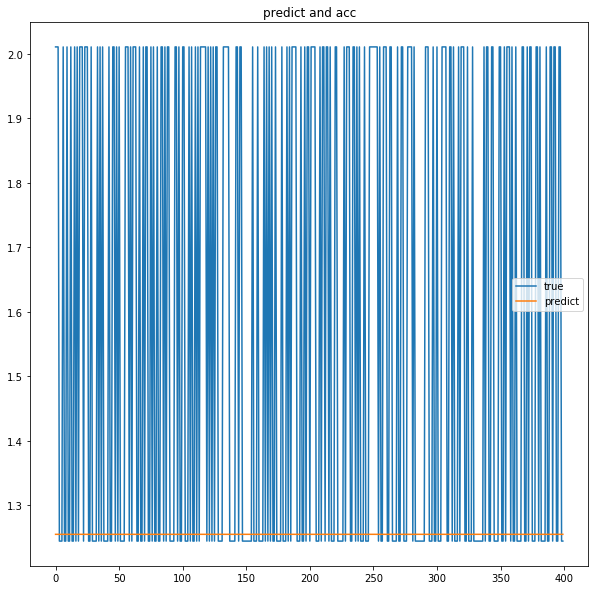

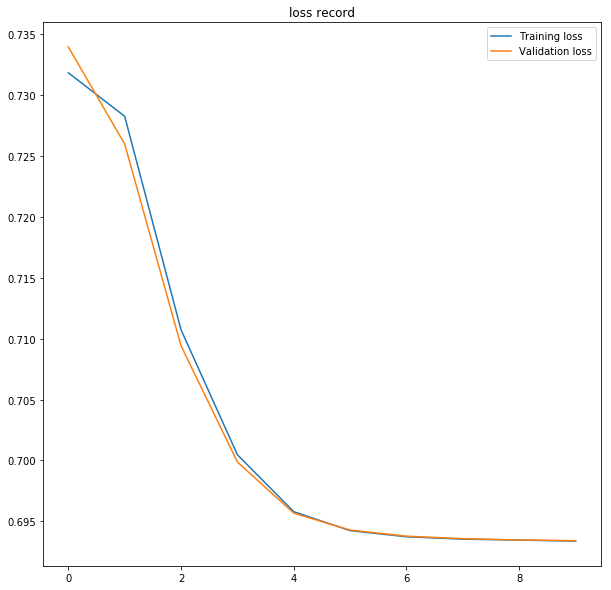

In [41]:
exchange_rnn_trend_model.train(epochs = 10, re_train=True, keep_prob=1)